## check predicted results

In [1]:
import os
import json
import random
random.seed(1000)
from IPython.display import display
from PIL import Image, ImageDraw
import const

In [2]:
IMG_PATH = const.IMG_PATH
VAL_JSON = const.VAL_JSON
ROS_OCR_JSON = const.ROS_OCR_JSON
AZURE_OCR_PATH = const.AZURE_OCR_PATH

baseline_pred = const.PRED_JSON
baseline_az_pred = const.PRED_NEW_JSON

In [4]:
def prepare_qid_info_map(tvqa_data):
    return {i['question_id']:i for i in tvqa_data['data']}

def check_ans(d, td):
    
    ans = d["answer"].replace(" 's'","'s'")
    s = set(td["answers"])
    if ans in s:
        return True
    return False

def calc_acc(d, td):
    ans = d["answer"].replace(" 's'","'s'").lower()
    cnt = 0
    for ta in td["answers"]:
        if ans==ta.lower():
            cnt += 1
            if cnt >=3:
                return 1
    return cnt/3

baseline_data = json.load(open(baseline_pred))
az_data = json.load(open(baseline_az_pred))
tvqa_val_data = json.load(open(VAL_JSON))
ros_ocr_data = {x["image_id"]:x["ocr_info"] for x in json.load(open(ROS_OCR_JSON))["data"]}
val_qid_info_map = prepare_qid_info_map(tvqa_val_data)

baseline_data_t = {x["question_id"]:x for x in baseline_data if check_ans(x,val_qid_info_map[x["question_id"]])}
baseline_data_f = {x["question_id"]:x for x in baseline_data if not check_ans(x,val_qid_info_map[x["question_id"]])}
az_data_t = {x["question_id"]:x for x in az_data if check_ans(x,val_qid_info_map[x["question_id"]])}
az_data_f = {x["question_id"]:x for x in az_data if not check_ans(x,val_qid_info_map[x["question_id"]])}

print(len(baseline_data_t),len(baseline_data_f),len(az_data_t),len(az_data_f))

base_acc = 0
for x in baseline_data:
    base_acc += calc_acc(x,val_qid_info_map[x["question_id"]])
base_acc /= len(baseline_data)
print(f"BASE ACC: {base_acc}")

az_acc = 0
for x in az_data:
    az_acc += calc_acc(x,val_qid_info_map[x["question_id"]])
az_acc /= len(az_data)
print(f"NEW ACC: {az_acc}")
    
bt = set(baseline_data_t.keys())
bf = set(baseline_data_f.keys())
zt = set(az_data_t.keys())
zf = set(az_data_f.keys())
print(len(bt&zt),len(bf&zf),len(bt&zf),len(bf&zt))


2548 2452 2521 2479
BASE ACC: 0.4691999999999999
NEW ACC: 0.46279999999999993
2226 2157 322 295


In [5]:
baseline_data[0]

{'question_id': 37864,
 'image_id': '1063289460a573cb',
 'answer': '12-0003',
 'pred_source': ['OCR']}

In [6]:
def show_ros_ocr(im, data):
    imdraw = ImageDraw.Draw(im)
    IW, IH = im.size
    for entry in data:
        wd = entry["word"]
        box = entry["bounding_box"]
        w,h,tx,ty = box["width"]*IW, box["height"]*IH, box["top_left_x"]*IW, box["top_left_y"]*IH
        imdraw.rectangle([(tx,ty),(tx+w,ty+h)],width=3)
        #imdraw.text((tx+5,ty+5),wd)
    return im

def show_az_ocr(im, data):
    def draw_rec(imd,b,fil=(255,255,255),w=3):
        imd.line([(b[0],b[1]),(b[2],b[3])],fil,w)
        imd.line([(b[2],b[3]),(b[4],b[5])],fil,w)
        imd.line([(b[4],b[5]),(b[6],b[7])],fil,w)
        imd.line([(b[6],b[7]),(b[0],b[1])],fil,w)
    imdraw = ImageDraw.Draw(im)
    IW, IH = im.size
    for entry in data:
        lbox = entry["bounding_box"]
        draw_rec(imdraw, lbox, fil=(255,0,0),w=5)
        for wentry in entry["words"]:
            wd = wentry["text"]
            wbox = wentry["bounding_box"]
            draw_rec(imdraw,wbox)
            #imdraw.text((wbox[0]+5,wbox[1]+5),wd)
    return im

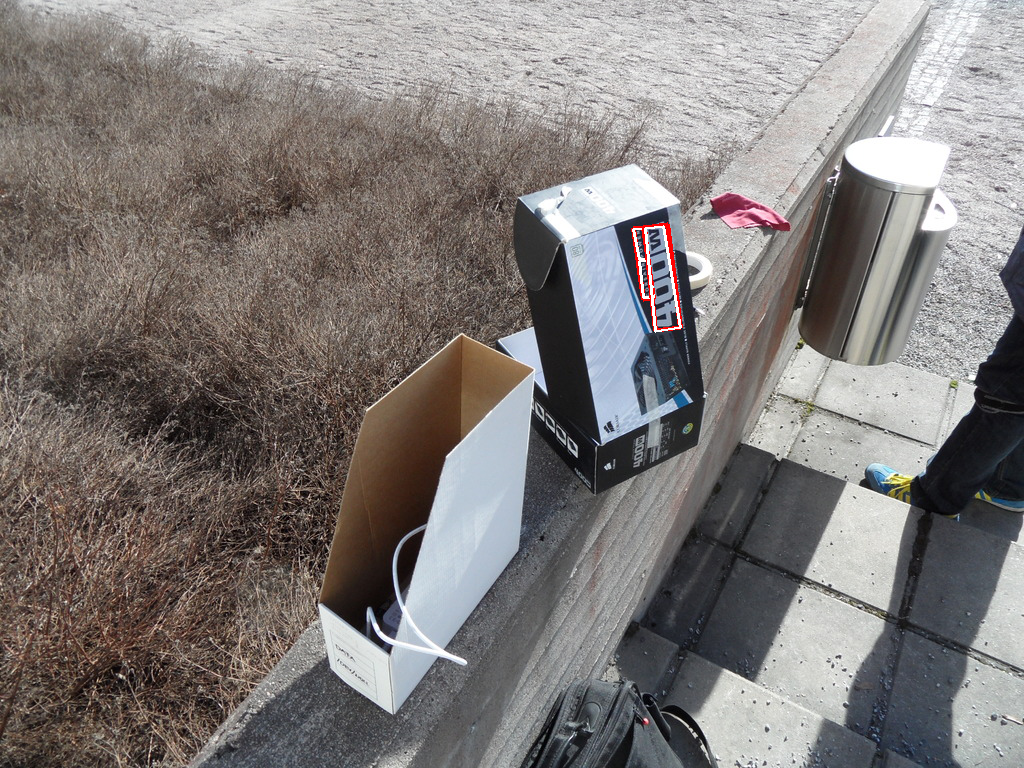

Question: what is in the box?
Ground truth: ['power supply', '400w', 'answering does not require reading text in the image', 'power fan', 'no text in image', '400w', 'unanswerable', 'power supply', 'power supply', 'answering does not require reading text in the image']

Azure: ['CORSAIR POWER', '400W']
Prediction: unanswerable
Prediction source: ['VOCAB']
Old Prediction: power
Old Prediction source: ['VOCAB']


In [51]:
# randomly choose examples
qid = random.choice(list(zt&bf))
pred_info = az_data_t[qid]
orig_pred_info = baseline_data_f[qid]

# visualize
qid = pred_info['question_id']
iid = pred_info['image_id']
gt_info = val_qid_info_map[qid]
pred_im_path = os.path.join(IMG_PATH, '{}.jpg'.format(gt_info['image_id']))

#im = Image.open(pred_im_path)
#im_ros = show_ros_ocr(im,ros_ocr_data[iid])
#ros_pred_text = [x["word"] for x in ros_ocr_data[iid]]
#display(im_ros)

im = Image.open(pred_im_path)
az_ocr_data = json.load(open(os.path.join(AZURE_OCR_PATH,iid+".json")))
im_az = show_az_ocr(im,az_ocr_data["lines"])
az_pred_text = [x["text"] for x in az_ocr_data["lines"]]
display(im_az)


print('Question: {}'.format(gt_info['question']))
print('Ground truth: {}'.format(gt_info['answers']))
print()
print("Azure:", az_pred_text)
print('Prediction: {}'.format(pred_info['answer']))
print('Prediction source: {}'.format(pred_info['pred_source']))
#print()
#print("Rosetta:", ros_pred_text)
print("Old Prediction: {}".format(orig_pred_info["answer"]))
print('Old Prediction source: {}'.format(orig_pred_info['pred_source']))


